In [2]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import TestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASsplicedmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASApplicationSpliced/TASObsTrends/ERA5TrendMap19792021.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split(path_to_data)


In [6]:
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, optimizers


# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=4e-5, restore_best_weights=True)

for model_idx in range(len(ModelNames)):
    
    # reshape predictor data
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingPredictorTimePeriod = np.reshape(TrainingPredictorData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 72*144))
    TrainingTargetTimePeriod = np.reshape(TrainingTargetData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 2, 3))
    
    X_train = TrainingPredictorTimePeriod[:,:,:]
    X_train = np.reshape(X_train, (len(X_train)*26,72*144))
    Y_train = TrainingTargetTimePeriod[:,:,:,:]
    Y_train = np.reshape(Y_train, (len(Y_train)*26,2,3))
    Y_train = Y_train[:,:,0]#[:,1]
    
    X_val = TrainingPredictorTimePeriod[:,-1,:]
    Y_val = TrainingTargetTimePeriod[:,-1,:,:]
    Y_val = Y_val[:,:,0]#[:,1]


    X_test = TestingPredictorData[model_idx]
    Y_test = TestingTargetData[model_idx]
    Y_test = Y_test[:,:,0]#[:,1]

    # scale all data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train_scaled = t.transform(X_train)
    X_train_map = np.reshape(X_train_scaled, (len(X_train_scaled), 72,144,1))
    X_val_scaled = t.transform(X_val)
    X_test_scaled = t.transform(X_test)
    X_test_map = np.reshape(X_test_scaled, (len(X_test_scaled), 72,144,1))

    # Model Design
    pls = PLSRegression(n_components=2)
    pls.fit(X_train_scaled, Y_train)

    # Predict using trained model and find residuals
    Y_pred_train_pls = pls.predict(X_train_scaled)
    residuals = Y_train - Y_pred_train_pls
    
    # create CNN
    cnn = Sequential()
    cnn.add(layers.Conv2D(128, 3, activation='relu',  input_shape=(72, 144, 1)))
    cnn.add(layers.MaxPooling2D(3))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(2))
    cnn.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=1e-4))
    cnn.fit(X_train_map, residuals, epochs=100, verbose=1, validation_split=0.1, callbacks=[stop_early])
    cnn.save("/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_{modelname}.h5".format(modelname=ModelNames[model_idx]))

    # find predictions based on both models
    Y_pred_test_pls = pls.predict(X_test_scaled)
    Y_pred_cnn = cnn.predict(X_test_map)
    Y_pred = Y_pred_test_pls + Y_pred_cnn
    # Apply trained model to observations
    #Y_pred_Gistemp = MLmodel.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = MLmodel.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = MLmodel.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], Y_test, Y_pred])
    
    print(ModelNames[model_idx])
    print(stats.pearsonr(Y_test[:,0], Y_pred[:,0]))
    print(np.nanmean(np.square((Y_test[:,0] - Y_pred[:,0]))))
    print(np.nanmean(np.square((Y_test[:,1] - Y_pred[:,1]))))


Epoch 1/100
128/128 [==============================] - 25s 197ms/step - loss: 0.0034 - val_loss: 3.1754e-04
Epoch 2/100
128/128 [==============================] - 26s 206ms/step - loss: 2.6917e-04 - val_loss: 2.5088e-04
Epoch 3/100
128/128 [==============================] - 25s 199ms/step - loss: 2.0846e-04 - val_loss: 1.9915e-04
Epoch 4/100
128/128 [==============================] - 26s 201ms/step - loss: 1.9096e-04 - val_loss: 2.3071e-04
Epoch 5/100
128/128 [==============================] - 25s 198ms/step - loss: 1.5335e-04 - val_loss: 3.1751e-04
Epoch 6/100
128/128 [==============================] - 26s 201ms/step - loss: 1.3816e-04 - val_loss: 2.0188e-04
Epoch 7/100
128/128 [==============================] - 26s 201ms/step - loss: 1.0558e-04 - val_loss: 2.4220e-04
Epoch 8/100
1/1 [==============================] - 1s 611ms/step
edmaps/IPSL_CM6A_LR_TASspli
(0.7505275675702112, 0.007784579757413075)
0.00042959583453765703
0.0005735102384600107
Epoch 1/100
118/118 [==================

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

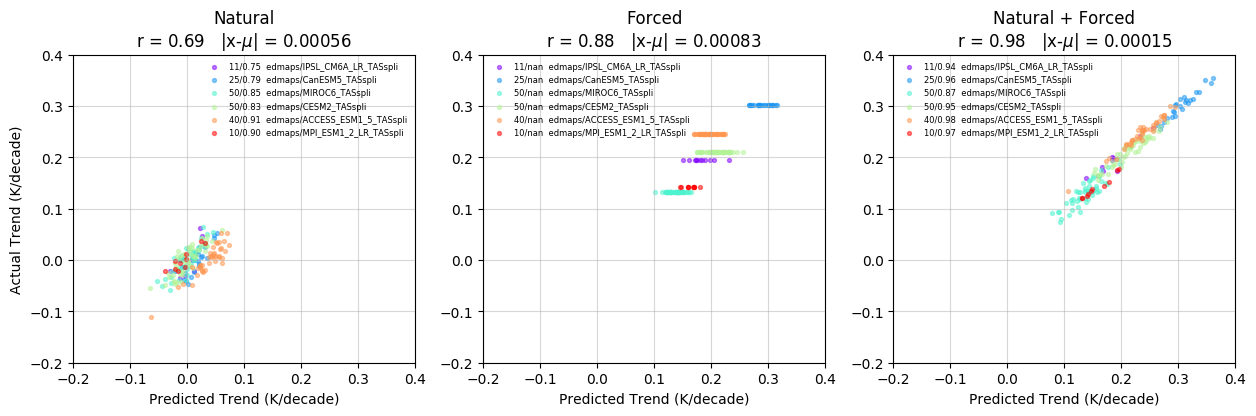

In [7]:
# Scaled CONV2d(128,3,64,2,32,2 maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

In [14]:
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, optimizers


# iterate over all CV folds (there should be eqaul number of CV folds as models)
observational_predictions = []
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=4e-5, restore_best_weights=True)

for model_idx in range(len(ModelNames)):
    
    # reshape predictor data
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingPredictorTimePeriod = np.reshape(TrainingPredictorData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 72*144))
    TrainingTargetTimePeriod = np.reshape(TrainingTargetData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 2, 3))
    
    X_train = TrainingPredictorTimePeriod[:,:,:]
    X_train = np.reshape(X_train, (len(X_train)*26,72*144))
    Y_train = TrainingTargetTimePeriod[:,:,:,:]
    Y_train = np.reshape(Y_train, (len(Y_train)*26,2,3))
    Y_train = Y_train[:,:,2]#[:,1]
    
    X_val = TrainingPredictorTimePeriod[:,-1,:]
    Y_val = TrainingTargetTimePeriod[:,-1,:,:]
    Y_val = Y_val[:,:,2]#[:,1]


    X_test = TestingPredictorData[model_idx]
    Y_test = TestingTargetData[model_idx]
    Y_test = Y_test[:,:,2]#[:,1]

    # scale all data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train_scaled = t.transform(X_train)
    X_train_map = np.reshape(X_train_scaled, (len(X_train_scaled), 72,144,1))
    X_val_scaled = t.transform(X_val)
    X_test_scaled = t.transform(X_test)
    X_test_map = np.reshape(X_test_scaled, (len(X_test_scaled), 72,144,1))

    # Model Design
    pls = PLSRegression(n_components=2)
    pls.fit(X_train_scaled, Y_train)

    # Predict using trained model and find residuals
    Y_pred_train_pls = pls.predict(X_train_scaled)
    residuals = Y_train - Y_pred_train_pls
    
    # create CNN
    cnn_models = ['/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_edmaps/IPSL_CM6A_LR_TASspli.h5',
                  '/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_edmaps/CanESM5_TASspli.h5', 
                  '/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_edmaps/MIROC6_TASspli.h5', 
                  '/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_edmaps/CESM2_TASspli.h5', 
                  '/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_edmaps/ACCESS_ESM1_5_TASspli.h5', 
                  '/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/PLS2_cnn128_3_3_MP3_edmaps/MPI_ESM1_2_LR_TASspli.h5']
    
    cnn = keras.models.load_model(cnn_models[model_idx])

    # find predictions based on both models
    Y_pred_test_pls = pls.predict(X_test_scaled)
    Y_pred_cnn = cnn.predict(X_test_map)
    Y_pred = Y_pred_test_pls + Y_pred_cnn
    
    # Apply trained model to observations
    # Apply trained model to observations
    observational_trend_maps_vector = [observational_trend_maps_reshaped,observational_trend_maps_reshaped]
    observational_trend_maps_reshaped_scaled = t.transform(observational_trend_maps_vector)
    Y_obs_pls = pls.predict(observational_trend_maps_reshaped_scaled)
    observational_trend_maps_recreated = np.reshape(observational_trend_maps_reshaped_scaled, (2,72,144,1))
    Y_obs_cnn = cnn.predict(observational_trend_maps_recreated)
    Y_obs = Y_obs_pls + Y_obs_cnn
    observational_predictions.append(Y_obs)
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], Y_test, Y_pred])
    
    print(ModelNames[model_idx])
    print(stats.pearsonr(Y_test[:,0], Y_pred[:,0]))
    print(np.nanmean(np.square((Y_test[:,0] - Y_pred[:,0]))))
    print(np.nanmean(np.square((Y_test[:,1] - Y_pred[:,1]))))


1/1 [==============================] - 0s 75ms/step
edmaps/IPSL_CM6A_LR_TASspli
(0.7044752724352924, 0.015504981695848567)
0.00048139904792616003
0.0007363464873575586
1/1 [==============================] - 0s 52ms/step
edmaps/CanESM5_TASspli
(0.7702290298356934, 6.694677661819321e-06)
0.000940095917742264
0.0014680115278674808
1/1 [==============================] - 0s 86ms/step
edmaps/MIROC6_TASspli
(0.7793657165841196, 2.6084542638405912e-11)
0.0006681557297055611
0.0004687803493241216
1/1 [==============================] - 0s 68ms/step
edmaps/CESM2_TASspli
(0.7088982463124556, 8.365919111415873e-09)
0.0004475028885332688
0.0005619534033174777
1/1 [==============================] - 0s 64ms/step
edmaps/ACCESS_ESM1_5_TASspli
(0.8702705684997014, 3.0202190085429617e-13)
0.0021480733605831704
0.0051061408222972254
1/1 [==============================] - 0s 79ms/step
edmaps/MPI_ESM1_2_LR_TASspli
(0.9064467408876605, 0.0002989542606966618)
0.000130921462776619
0.002966108400444454


In [15]:
np.nanmean(observational_predictions, axis=0)

array([[-0.01978715,  0.21366107],
       [-0.01978715,  0.21366107]])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

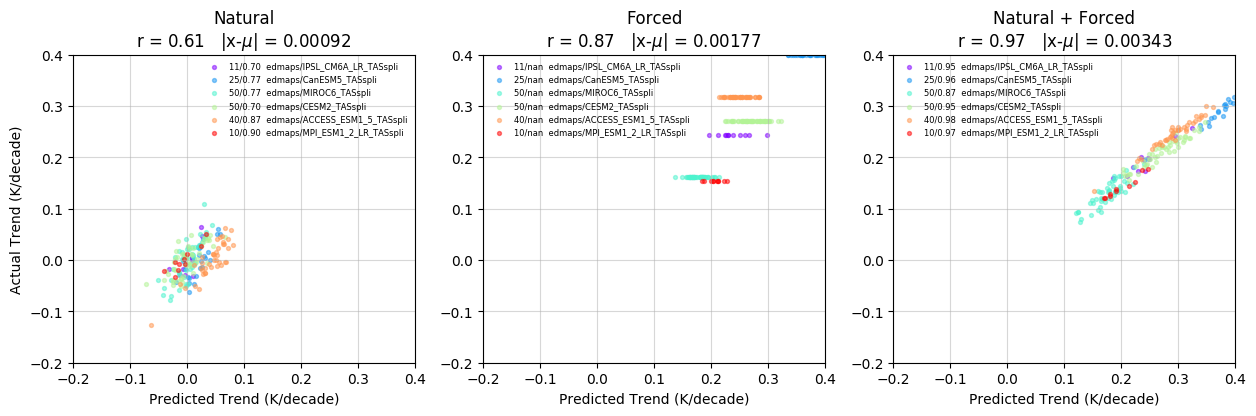

In [11]:
# Scaled CONV2d(128,3,64,2,32,2 maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])